In [2]:
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report




In [3]:
base = r"C:\Users\SIDDHAARTH\Desktop\Video project\processed_data"

angry   = os.path.join(base, "angry")
disgust = os.path.join(base, "disgust")
fear    = os.path.join(base, "fear")
happy   = os.path.join(base, "happy")
neutral = os.path.join(base, "neutral")
sad     = os.path.join(base, "sad")


def show_images_from_folder(folder_path, n=12, cols=4, figsize=(10,8)):
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
             if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if not files:
        print("No images found in:", folder_path)
        return
    
    files = files[:n]  # take first n
    
    rows = (n + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, path in enumerate(files):
        img = Image.open(path).convert('RGB')
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(folder_path).capitalize())
        print(img.size)

    plt.tight_layout()
    plt.show()


(96, 96)
(96, 96)
(96, 96)
(96, 96)


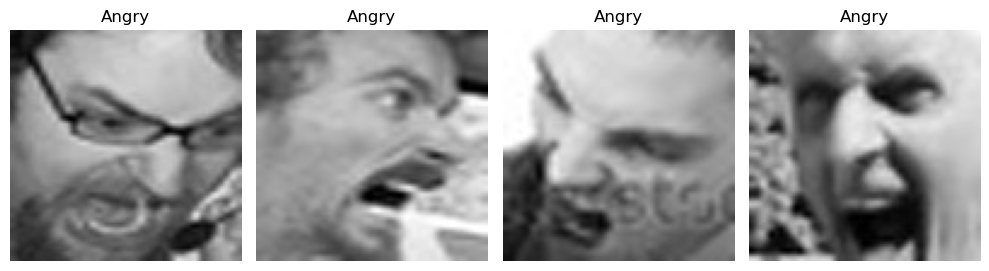

(96, 96)
(96, 96)
(96, 96)
(96, 96)


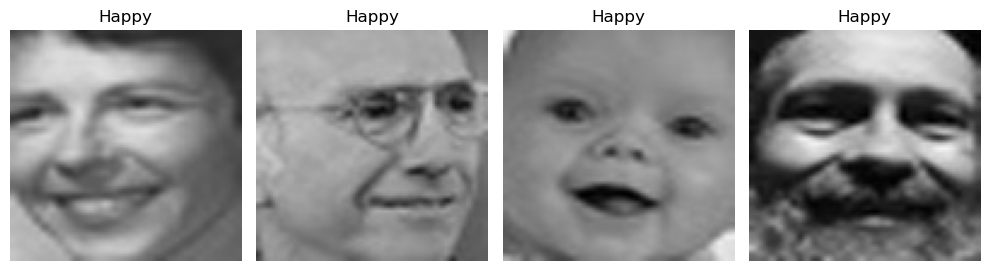

(96, 96)
(96, 96)
(96, 96)
(96, 96)


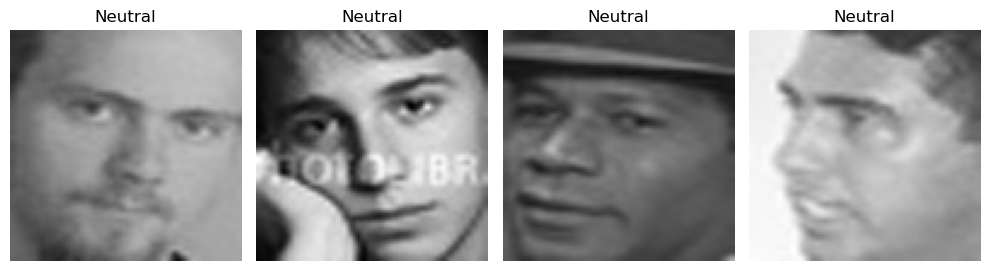

In [4]:
show_images_from_folder(angry, n=4)
show_images_from_folder(happy, n=4)
show_images_from_folder(neutral, n=4)



In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([ 
    transforms.ToTensor()         
])
dataset = datasets.ImageFolder(r"C:\Users\SIDDHAARTH\Desktop\Video project\processed_data", transform=transform)




In [6]:
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
dev_size = len(dataset) - test_size - train_size

train_ds , test_ds , dev_ds = random_split(
    dataset,
    [train_size , test_size ,dev_size],
    generator=torch.Generator().manual_seed(42) 
)



In [7]:
train_loader_temp = DataLoader(train_ds , batch_size = 32 ,shuffle=True)

std_train = 0
mean_train = 0
total_train = 0

for images , _ in tqdm(train_loader_temp):
    imgs = images.view(images.size(0) , images.size(1) , -1)
    mean_train += imgs.mean(2).sum(0)
    std_train += imgs.std(2).sum(0)
    total_train += imgs.shape[0]

mean_train /= total_train
std_train /= total_train



100%|██████████| 1245/1245 [01:38<00:00, 12.67it/s]


In [8]:
dev_loader_temp = DataLoader(dev_ds , batch_size = 32 ,shuffle=True)

std_dev = 0
mean_dev = 0
total_dev = 0

for images , _ in tqdm(dev_loader_temp):
    imgs = images.view(images.size(0) , images.size(1) , -1)
    mean_dev += imgs.mean(2).sum(0)
    std_dev += imgs.std(2).sum(0)
    total_dev += imgs.shape[0]

mean_dev /= total_dev
std_dev /= total_train



100%|██████████| 156/156 [00:04<00:00, 36.24it/s]


In [9]:
print(mean_train , std_train)
print(mean_dev ,  std_dev)

tensor([0.5456, 0.4975, 0.4794]) tensor([0.1993, 0.1924, 0.1891])
tensor([0.5453, 0.4979, 0.4794]) tensor([0.0249, 0.0241, 0.0236])


In [10]:
mean_list_train = mean_train.tolist()
std_list_train = std_train.tolist() 

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_list_train , std_list_train)
])



In [11]:
mean_list_dev = mean_dev.tolist()
std_list_dev = std_dev.tolist()

dev_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_list_dev , std_list_dev)
])

In [12]:
dataset_normalized = datasets.ImageFolder(r"C:\Users\SIDDHAARTH\Desktop\Video project\processed_data")

train_ds_final = torch.utils.data.Subset(
    datasets.ImageFolder(r"C:\Users\SIDDHAARTH\Desktop\Video project\processed_data", transform=train_transform), train_ds.indices
)

dev_ds_final = torch.utils.data.Subset(
    datasets.ImageFolder(r"C:\Users\SIDDHAARTH\Desktop\Video project\processed_data", transform=dev_transform), dev_ds.indices
)

test_ds_final = torch.utils.data.Subset(
    datasets.ImageFolder(r"C:\Users\SIDDHAARTH\Desktop\Video project\processed_data", transform=dev_transform), test_ds.indices
)


In [13]:
train_loader = DataLoader(train_ds_final, batch_size=64, shuffle=True)
val_loader   = DataLoader(dev_ds_final, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds_final, batch_size=64, shuffle=False)

In [14]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))


623
78
78


IT means that there is 623 batches of the train set and each batch has 32 images!!

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [16]:
class Training_loop(nn.Module):
    def __init__(self , num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3 , 16 , 3 , padding=1)
        self.conv2 = nn.Conv2d(16 , 32 , 3 , padding=1)
        self.conv3 = nn.Conv2d(32 , 64 , 3 , padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(64 * 12 * 12, num_classes)

    def forward(self , x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        #this is the 1st Conv layer!!
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        #this is the 2nd Conv layer!!
                
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool(x)
        #this is the 3rd Conv layer!!
        x = torch.flatten(x , 1)
        return self.fc(x)
    


In [17]:

try:
    classes = train_loader.dataset.dataset.classes 
    num_classes = len(classes)
    print("Inferred classes from ImageFolder:", classes)
except Exception:
   
    labels = []
    for _, y in train_loader.dataset:
        labels.append(int(y))
    num_classes = int(max(labels)) + 1
    classes = [str(i) for i in range(num_classes)]
    print("Inferred num_classes from data:", num_classes)


Inferred classes from ImageFolder: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [18]:

model = Training_loop(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
print("Model params:", sum(p.numel() for p in model.parameters()))


Model params: 88103


In [19]:
loss_list = []
accuracy_per_epoch = []
epoch = 10
for i in range(epoch):
    model.train()
    #loss = 0
    loss_now = 0
    for images , labels in train_loader:
        image = images.to(device)
        label = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs , label)
        loss.backward()
        optimizer.step()
        loss_now += loss.item()
    loss_per_epoch = loss_now/len(train_loader)
    loss_list.append(loss_per_epoch)

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images , labels in val_loader:
            image = images.to(device)
            label = labels.to(device)
            output = model(image)
            _,predicted = torch.max(output, 1)
            total += label.size(0)
            correct+=(predicted == label).sum().item()
    accuracy = (correct/total) * 100
    accuracy_per_epoch.append(accuracy)     
    print(f"Epoch {i+1}, Loss: {loss_per_epoch:.4f}, Val Acc: {accuracy:.2f}%")   





Epoch 1, Loss: 1.3744, Val Acc: 43.44%
Epoch 2, Loss: 1.1028, Val Acc: 53.91%
Epoch 3, Loss: 0.9876, Val Acc: 56.10%
Epoch 4, Loss: 0.9052, Val Acc: 57.70%
Epoch 5, Loss: 0.8380, Val Acc: 51.11%
Epoch 6, Loss: 0.7787, Val Acc: 58.45%
Epoch 7, Loss: 0.7283, Val Acc: 55.73%
Epoch 8, Loss: 0.6795, Val Acc: 54.35%
Epoch 9, Loss: 0.6352, Val Acc: 56.34%
Epoch 10, Loss: 0.5963, Val Acc: 57.04%


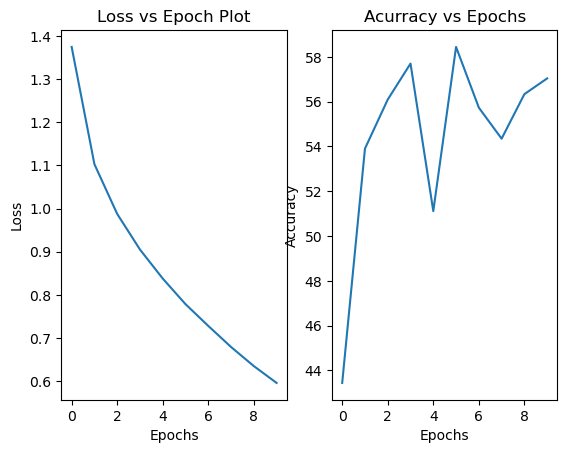

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1 , 2, 1)
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epoch Plot")

plt.subplot(1 ,2,2)
plt.plot(accuracy_per_epoch)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Acurracy vs Epochs")
#not  a good accuracy!!

plt.show()